# AIND - Project 2 - Build a Forward-Planning Agent
## Report

### Environment
The results were produced on a desktop computer with the following specification:
- OS: Ubuntu 20.04.2 LTS (64 bit)
- Memory: 23,4 GiB
- Processor: Intel Core i7-4790K CPU@4Ghz * 8
- GNU bash, version 5.0.17(1)-release (x86_64-pc-linux-gnu)
- Conda virutal environment: Python: 3.9.5

### Obtaining the data:
The provided `run_search.py` script was run the following way:
```bash 
(project2) $ parallel python run_search.py -p 1 2 -s {1} ::: {1..11} > results.txt
```
The GNU Parallel was utilized to run the processes simultaneously (this likely saves time for porblem 3 and 4, but ptobably not for problems 1 and 2 due to the overhead of each python process)
The `results.txt` was processed to consolidate the data in a nearly tabular format in an new file:
```bash
grep '^Solving*' -A 5 results.txt | grep -v -e '^$' > result_summary.txt
```

The `result_summary.txt` consist of records like this for each test scenario:
```text
Solving Air Cargo Problem 1 using breadth_first_search...
# Actions   Expansions   Goal Tests   New Nodes
    20          43          56         178    
Plan length: 6  Time elapsed in seconds: 0.0017708629602566361
--
```



In [1]:
import re
import collections
import pandas as pd

Result = collections.namedtuple('Result',['problem', 'search', 'heuristic', 'actions', 'exp', 'goal_tests', 'new_nodes', 'length', 'duration'])

def make_records(file_name: str) -> list[Result]:    
    with open(file_name, "r") as f:
        lines = f.readlines()

    longlines = []
    for l in lines:
        match_problem = re.compile(r"^Solving Air Cargo Problem (\d).[a-z]+ ([a-z].+)...$").match(l)
        if match_problem:
            current = match_problem.group(1)
            search = match_problem.group(2)
            match_h = re.compile(r".*with (\w+)").match(l)
            if match_h:
                heuristic = match_h.group(1)
            else:
                heuristic = None
            continue
        m_aegn = re.compile(r"^\s+(\d+)\s+(\d+)\s+(\d+)\s+(\d+)\s+$").match(l)    
        if m_aegn:
            (action, exp, goal_tests, new_nodes) = (m_aegn.group(1), m_aegn.group(2), m_aegn.group(3), m_aegn.group(4))
            continue

        m_length_dur = re.compile(r"^Plan length: (\d+).+Time elapsed in seconds: (\d+.?\d+)").match(l)
        if m_length_dur:        
            final = Result(current, search, heuristic, action, exp, goal_tests, new_nodes, m_length_dur.group(1), m_length_dur.group(2))
            longlines.append(final)
    
    return longlines

def make_dataframe(records: list[Result]) -> pd.DataFrame:
    df = pd.DataFrame.from_records(records, columns=Result._fields)
    df['exp'] = df['exp'].astype(int)
    df['actions'] = df['actions'].astype(int)
    df['goal_tests'] = df['goal_tests'].astype(int)
    df['new_nodes'] = df['new_nodes'].astype(int)
    df['length'] = df['length'].astype(int)
    df['duration'] = df['duration'].astype(float)
    rgx  = re.compile(r"([a-z|_]+)")
    df['algorithm'] = [rgx.match(x).group(1) if rgx.match(x) else None for x in df.search]
    df.style.set_properties(subset=["search"], **{'text-align': 'left'})
    return df

In [2]:
df12 = make_dataframe(make_records("result_summary.txt"))
df12

,problem,search,heuristic,actions,exp,goal_tests,new_nodes,length,duration,algorithm
0,1,greedy_best_first_graph_search with h_unmet_goals,h_unmet_goals,20,7,9,29,6,0.001078,greedy_best_first_graph_search
1,2,greedy_best_first_graph_search with h_unmet_goals,h_unmet_goals,72,17,19,170,9,0.011406,greedy_best_first_graph_search
2,1,breadth_first_search,None,20,43,56,178,6,0.004031,breadth_first_search
3,2,breadth_first_search,None,72,3343,4609,30503,9,1.189047,breadth_first_search
4,1,astar_search with h_unmet_goals,h_unmet_goals,20,50,52,206,6,0.005937,astar_search
5,2,astar_search with h_unmet_goals,h_unmet_goals,72,2467,2469,22522,9,1.333430,astar_search
6,1,depth_first_graph_search,None,20,21,22,84,20,0.002146,depth_first_graph_search
7,2,depth_first_graph_search,None,72,624,625,5602,619,1.530638,depth_first_graph_search
8,1,uniform_cost_search,None,20,60,62,240,6,0.005838,uniform_cost_search
9,2,uniform_cost_search,None,72,5154,5156,46618,9,1.983656,uniform_cost_search


In [3]:
df12.groupby(by=["problem", "algorithm", "heuristic"], dropna=False).sum()

actions   exp  \
problem algorithm                      heuristic                      
1       astar_search                   h_pg_levelsum       20    28   
                                       h_pg_maxlevel       20    43   
                                       h_pg_setlevel       20    33   
                                       h_unmet_goals       20    50   
        breadth_first_search           NaN                 20    43   
        depth_first_graph_search       NaN                 20    21   
        greedy_best_first_graph_search h_pg_levelsum       20     6   
                                       h_pg_maxlevel       20     6   
                                       h_pg_setlevel       20     6   
                                       h_unmet_goals       20     7   
        uniform_cost_search            NaN                 20    60   
2       astar_search                   h_pg_levelsum       72   357   
                                       h_pg_maxlevel       72  2887   
                                       h_pg_setlevel       72  1037   
                                       h_unmet_goals       72  2467   
        breadth_first_search           NaN                 72  3343   
        depth_first_graph_search       NaN                 72   624   
        greedy_best_first_graph_search h_pg_levelsum       72     9   
                                       h_pg_maxlevel       72    27   
                                       h_pg_setlevel       72     9   
                                       h_unmet_goals       72    17   
        uniform_cost_search            NaN                 72  5154   

                                                      goal_tests  new_nodes  \
problem algorithm                      heuristic                              
1       astar_search                   h_pg_levelsum          30        122   
                                       h_pg_maxlevel          45        180   
                                       h_pg_setlevel          35        138   
                                       h_unmet_goals          52        206   
        breadth_first_search           NaN                    56        178   
        depth_first_graph_search       NaN                    22         84   
        greedy_best_first_graph_search h_pg_levelsum           8         28   
                                       h_pg_maxlevel           8         24   
                                       h_pg_setlevel           8         28   
                                       h_unmet_goals           9         29   
        uniform_cost_search            NaN                    62        240   
2       astar_search                   h_pg_levelsum         359       3426   
                                       h_pg_maxlevel        2889      26594   
                                       h_pg_setlevel        1039       9605   
                                       h_unmet_goals        2469      22522   
        breadth_first_search           NaN                  4609      30503   
        depth_first_graph_search       NaN                   625       5602   
        greedy_best_first_graph_search h_pg_levelsum          11         86   
                                       h_pg_maxlevel          29        249   
                                       h_pg_setlevel          11         84   
                                       h_unmet_goals          19        170   
        uniform_cost_search            NaN                  5156      46618   

                                                      length    duration  
problem algorithm                      heuristic                          
1       astar_search                   h_pg_levelsum       6    0.733620  
                                       h_pg_maxlevel       6    0.778406  
                                       h_pg_setlevel       6    2.463442  
                                       h_unmet_goals       6    0.005937  
  

In [4]:
table = pd.pivot_table(df12,index=['problem','algorithm','heuristic'], values=['duration', 'exp', 'length'], aggfunc=sum)
table

duration   exp  length
problem algorithm                      heuristic                              
1       astar_search                   h_pg_levelsum    0.733620    28       6
                                       h_pg_maxlevel    0.778406    43       6
                                       h_pg_setlevel    2.463442    33       6
                                       h_unmet_goals    0.005937    50       6
        greedy_best_first_graph_search h_pg_levelsum    0.290513     6       6
                                       h_pg_maxlevel    0.223862     6       6
                                       h_pg_setlevel    0.946502     6       6
                                       h_unmet_goals    0.001078     7       6
2       astar_search                   h_pg_levelsum   86.600762   357       9
                                       h_pg_maxlevel  483.368170  2887       9
                                       h_pg_setlevel  791.994878  1037       9
                                       h_unmet_goals    1.333430  2467       9
        greedy_best_first_graph_search h_pg_levelsum    4.177993     9       9
                                       h_pg_maxlevel   12.724622    27       9
                                       h_pg_setlevel   11.029576     9       9
                                       h_unmet_goals    0.011406    17       9

<AxesSubplot:xlabel='problem,algorithm,heuristic'>

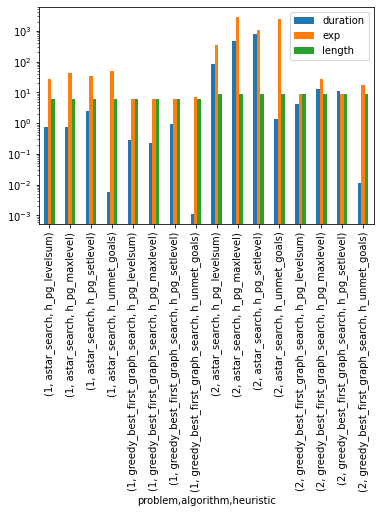

In [5]:
table.plot(kind='bar', logy=True)

<AxesSubplot:xlabel='problem,algorithm,heuristic'>

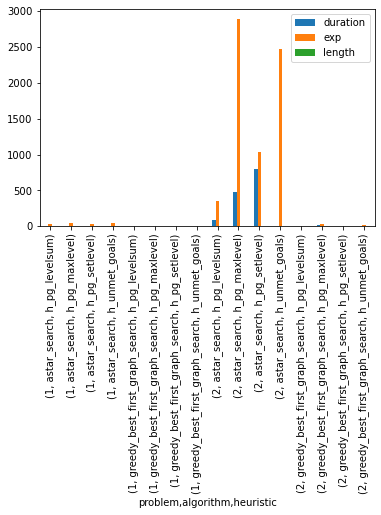

In [6]:
table.plot(kind='bar', logy=False)

### Conclusion after problems 1 and 2
The `depth_first_graph_search` completely misses the mark, as the proposed solution is way too far from optimal. Any number of extra fliights (or even simpler physical actions) are way more expensive than the potential savings in computational time. 


The clear winner based on both scales (problem 1 and 2) is:  
## `greedy_best_first_graph_search with h_unmet_goals`


I consider the following parameters of each algorithm important:
- `Lenght`: the numer of actions in the proposed execution plan
- `Duration` : How long does the computation take for each problem
- The size of the grap (`exp` and `new_nodes`), to roughly corroborate this point, i calaculatd the correlation between the two, which is close to 1 (see next cell)  
### Governing initial porpositions
- Any physical actions, especially extra flights are way more expensive then computer power; thus the former offests any savings by using a "cheaper", but suboptimal algorithm.
- Scaling memory usage is cheaper than processing power: it is usually easyer to boost the computer by adding more memory than adding more processor cores. This latter may necessiate rewriting algorithms and to optimize for parallel computing (including human time and effort).
- Other considerations prevail when the system has to respons in real time, which is not the part of the current use case

In [7]:
df12['exp'].corr(df12['new_nodes'])

0.9999273724384378

In [8]:
df12['exp'].corr(df12['goal_tests'])

0.9872312318733545

As the graph shows the `A*` search grows exponentially in any case. 

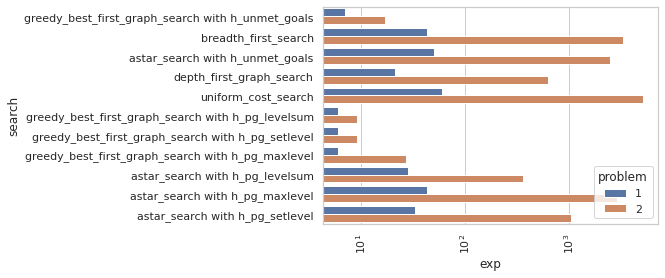

In [20]:
from matplotlib import pyplot
import seaborn as sns
sns.set_style("whitegrid")
p = sns.barplot(x="exp", y = "search", hue="problem", data=df12)
plt.xticks(rotation=90)
plt.xscale("log")
plt.show()

## Problems 3 and 4

```bash
parallel python run_search.py -p 3 4 -s {1} ::: {1..9} | tee results_prob34.txt
grep '^Solving*' -A 5 results_prob34.txt | grep -v -e '^$' > result_prob34_summary.txt
```
Let's extract the data for problems 3 and 4 and concatenate the data frames for better context.
I'd run the test the for problems 3-4 with solutions 1-9, ie. I only dropped A* with `h_pg_max_level` and `h_pg_set_level`, due to their expected long computing time.  
The unfiltered results summary is exhibited in the next table:

In [10]:
df34 = make_dataframe(make_records("result_prob34_summary.txt"))
df34

,problem,search,heuristic,actions,exp,goal_tests,new_nodes,length,duration,algorithm
0,3,greedy_best_first_graph_search with h_unmet_goals,h_unmet_goals,88,25,27,230,15,0.021266,greedy_best_first_graph_search
1,4,greedy_best_first_graph_search with h_unmet_goals,h_unmet_goals,104,29,31,280,18,0.036156,greedy_best_first_graph_search
2,3,greedy_best_first_graph_search with h_pg_levelsum,h_pg_levelsum,88,14,16,126,14,11.187342,greedy_best_first_graph_search
3,4,greedy_best_first_graph_search with h_pg_levelsum,h_pg_levelsum,104,17,19,165,17,14.288633,greedy_best_first_graph_search
4,3,astar_search with h_unmet_goals,h_unmet_goals,88,7388,7390,65711,12,2.692799,astar_search
5,4,astar_search with h_unmet_goals,h_unmet_goals,104,34330,34332,328509,14,25.140462,astar_search
6,3,breadth_first_search,None,88,14663,18098,129625,12,6.281926,breadth_first_search
7,4,breadth_first_search,None,104,99736,114953,944130,14,37.637637,breadth_first_search
8,3,uniform_cost_search,None,88,18510,18512,161936,12,8.537571,uniform_cost_search
9,4,uniform_cost_search,None,104,113339,113341,1066413,14,44.945992,uniform_cost_search


The same data, gruped by problem, algorithm and heuristic:

In [11]:
df34.groupby(by=["problem", "algorithm", "heuristic"], dropna=False).sum()

actions     exp  \
problem algorithm                      heuristic                        
3       astar_search                   h_pg_levelsum       88     369   
                                       h_unmet_goals       88    7388   
        breadth_first_search           NaN                 88   14663   
        depth_first_graph_search       NaN                 88     408   
        greedy_best_first_graph_search h_pg_levelsum       88      14   
                                       h_pg_maxlevel       88      21   
                                       h_pg_setlevel       88      35   
                                       h_unmet_goals       88      25   
        uniform_cost_search            NaN                 88   18510   
4       astar_search                   h_pg_levelsum      104    1208   
                                       h_unmet_goals      104   34330   
        breadth_first_search           NaN                104   99736   
        depth_first_graph_search       NaN                104   25174   
        greedy_best_first_graph_search h_pg_levelsum      104      17   
                                       h_pg_maxlevel      104      56   
                                       h_pg_setlevel      104     107   
                                       h_unmet_goals      104      29   
        uniform_cost_search            NaN                104  113339   

                                                      goal_tests  new_nodes  \
problem algorithm                      heuristic                              
3       astar_search                   h_pg_levelsum         371       3403   
                                       h_unmet_goals        7390      65711   
        breadth_first_search           NaN                 18098     129625   
        depth_first_graph_search       NaN                   409       3364   
        greedy_best_first_graph_search h_pg_levelsum          16        126   
                                       h_pg_maxlevel          23        195   
                                       h_pg_setlevel          37        345   
                                       h_unmet_goals          27        230   
        uniform_cost_search            NaN                 18512     161936   
4       astar_search                   h_pg_levelsum        1210      12210   
                                       h_unmet_goals       34332     328509   
        breadth_first_search           NaN                114953     944130   
        depth_first_graph_search       NaN                 25175     228849   
        greedy_best_first_graph_search h_pg_levelsum          19        165   
                                       h_pg_maxlevel          58        580   
                                       h_pg_setlevel         109       1164   
                                       h_unmet_goals          31        280   
        uniform_cost_search            NaN                113341    1066413   

                                                      length    duration  
problem algorithm                      heuristic                          
3       astar_search                   h_pg_levelsum      12  129.196758  
                                       h_unmet_goals      12    2.692799  
        breadth_first_search           NaN                12    6.281926  
        depth_first_graph_search       NaN               392    0.625750  
        greedy_best_first_graph_search h_pg_levelsum      14   11.187342  
                                       h_pg_maxlevel      13   18.385796  
                                       h_pg_setlevel      17   74.453106  
                                       h_unmet_goals      15    0.021266  
        uniform_cost_search            NaN                12    8.537571  
4       astar_search                   h_pg_levelsum      15  720.167901  
                                       h_unmet_goals      14   25.140462  
        breadth_first_search         

Arranged by heuristics:

In [12]:
table34 = pd.pivot_table(df34,index=['problem','algorithm','heuristic'], values=['duration', 'exp', 'length'], aggfunc=sum)
table34

duration    exp  \
problem algorithm                      heuristic                          
3       astar_search                   h_pg_levelsum  129.196758    369   
                                       h_unmet_goals    2.692799   7388   
        greedy_best_first_graph_search h_pg_levelsum   11.187342     14   
                                       h_pg_maxlevel   18.385796     21   
                                       h_pg_setlevel   74.453106     35   
                                       h_unmet_goals    0.021266     25   
4       astar_search                   h_pg_levelsum  720.167901   1208   
                                       h_unmet_goals   25.140462  34330   
        greedy_best_first_graph_search h_pg_levelsum   14.288633     17   
                                       h_pg_maxlevel   45.765652     56   
                                       h_pg_setlevel  233.629217    107   
                                       h_unmet_goals    0.036156     29   

                                                      length  
problem algorithm                      heuristic              
3       astar_search                   h_pg_levelsum      12  
                                       h_unmet_goals      12  
        greedy_best_first_graph_search h_pg_levelsum      14  
                                       h_pg_maxlevel      13  
                                       h_pg_setlevel      17  
                                       h_unmet_goals      15  
4       astar_search                   h_pg_levelsum      15  
                                       h_unmet_goals      14  
        greedy_best_first_graph_search h_pg_levelsum      17  
                                       h_pg_maxlevel      17  
                                       h_pg_setlevel      23  
                                       h_unmet_goals      18

This is the unified table with all raw data consolidated in one tabell

In [13]:
df = pd.concat([df12, df34], ignore_index=True)
df

,problem,search,heuristic,actions,exp,goal_tests,new_nodes,length,duration,algorithm
0,1,greedy_best_first_graph_search with h_unmet_goals,h_unmet_goals,20,7,9,29,6,0.001078,greedy_best_first_graph_search
1,2,greedy_best_first_graph_search with h_unmet_goals,h_unmet_goals,72,17,19,170,9,0.011406,greedy_best_first_graph_search
2,1,breadth_first_search,None,20,43,56,178,6,0.004031,breadth_first_search
3,2,breadth_first_search,None,72,3343,4609,30503,9,1.189047,breadth_first_search
4,1,astar_search with h_unmet_goals,h_unmet_goals,20,50,52,206,6,0.005937,astar_search
5,2,astar_search with h_unmet_goals,h_unmet_goals,72,2467,2469,22522,9,1.333430,astar_search
6,1,depth_first_graph_search,None,20,21,22,84,20,0.002146,depth_first_graph_search
7,2,depth_first_graph_search,None,72,624,625,5602,619,1.530638,depth_first_graph_search
8,1,uniform_cost_search,None,20,60,62,240,6,0.005838,uniform_cost_search
9,2,uniform_cost_search,None,72,5154,5156,46618,9,1.983656,uniform_cost_search


### Gorowth with problem size
The correlation betwen `exp`, `goal_tests` and `new_nodes` still holds, see chart and calculation

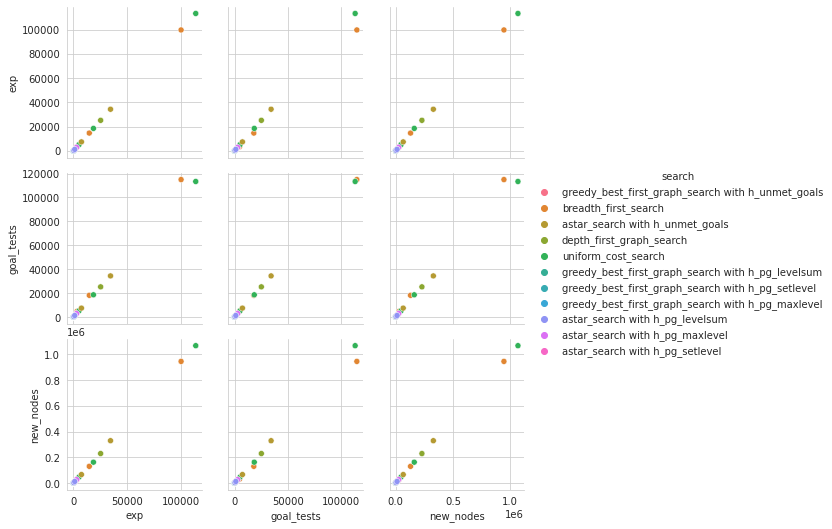

In [14]:
g = sns.PairGrid(df, vars=["exp", "goal_tests", "new_nodes"], hue="search")
#g.map_diag(sns.histplot)

g.map(sns.scatterplot)
g.add_legend()

In [15]:
df['exp'].corr(df['new_nodes'])


0.9999143717407907

In [16]:
df['exp'].corr(df['goal_tests'])

0.9971199544230299

See the development in durations for each search algorithm as the problem size grows.  
**Note** mind the logarithmic scale!

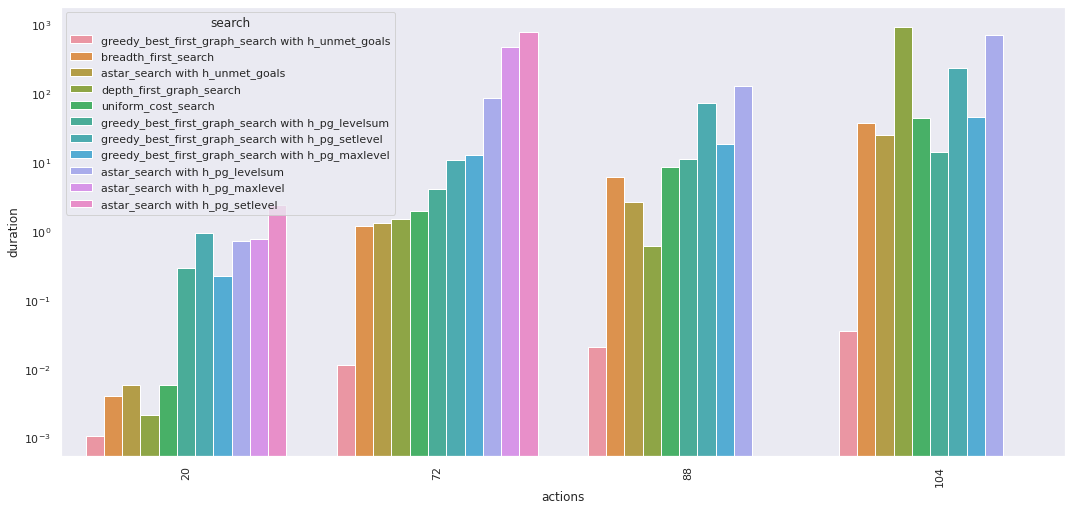

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")
#ax = sns.lineplot(y="duration", x = "actions", data=df[df["search"]=="breadth_first_search"])
fig, ax = plt.subplots()
fig.set_size_inches(18, 8.27)
ax = sns.barplot(y="duration", x = "actions", data=df, hue="search")
ax.set(yscale='log')
plt.xticks(rotation=90)
plt.show()

Here is the growth in number of expansions that roughly corresponds to memory use

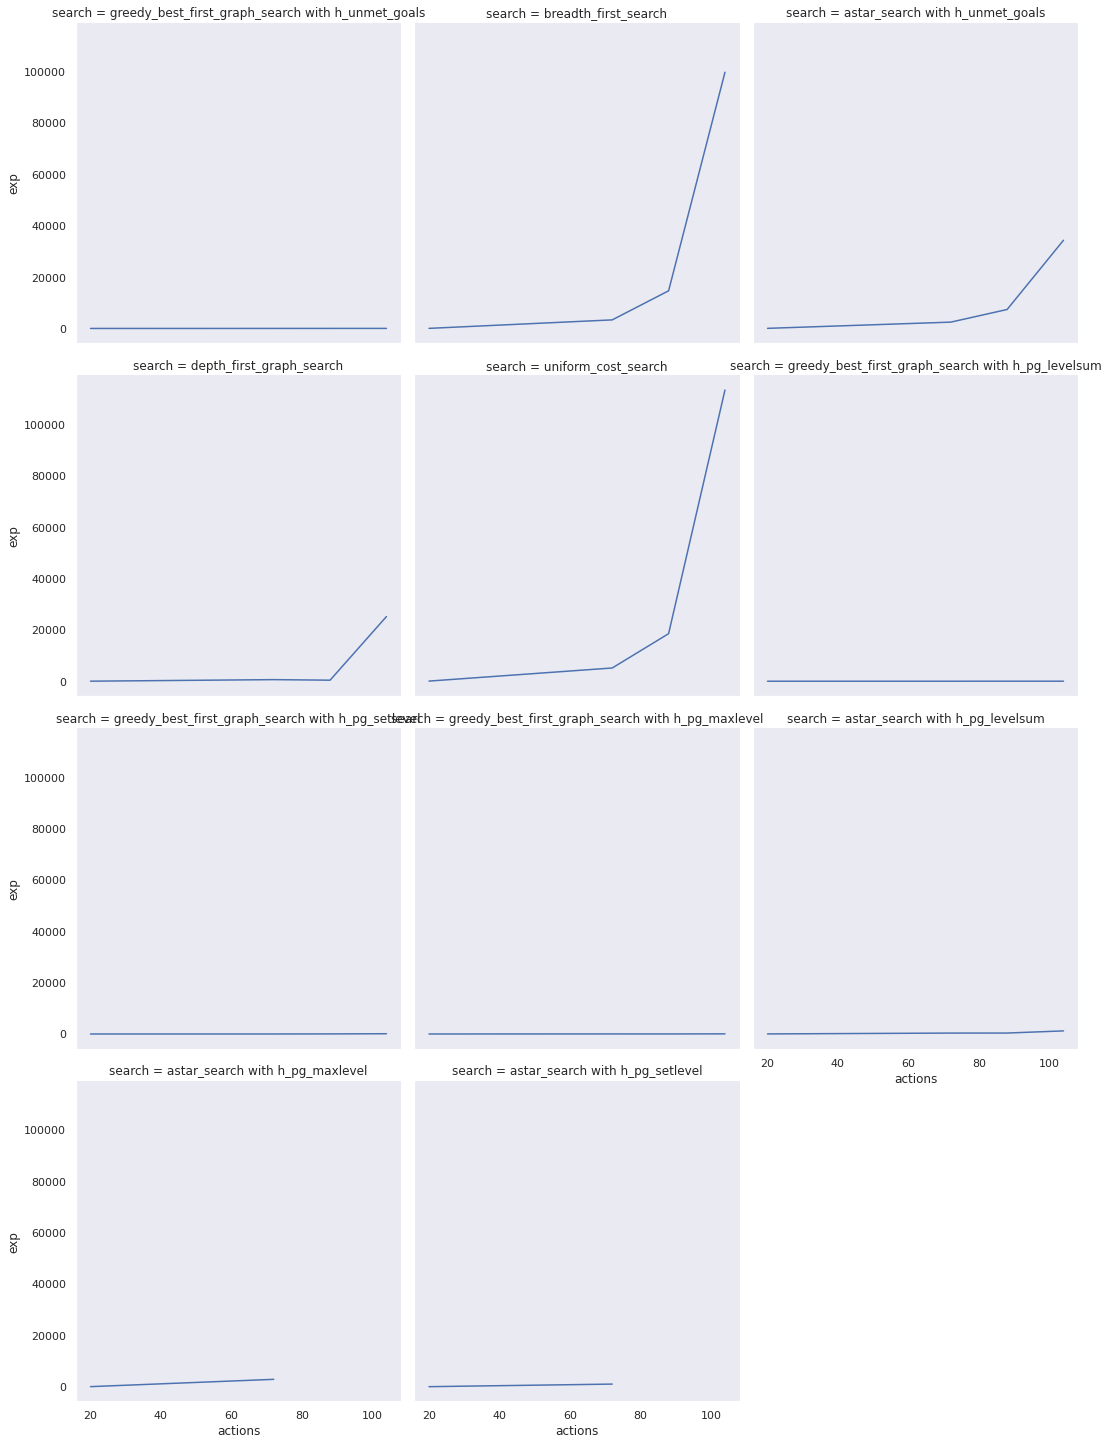

In [18]:
sns.relplot(data=df, x="actions", y="exp", col="search", col_wrap=3, kind="line")
#plt.ylim(0, 10000)

And the same plots against calculation time. The Y axis is culled to preserv the visibility of trends and still keep the linear perspective

(0.0, 400.0)

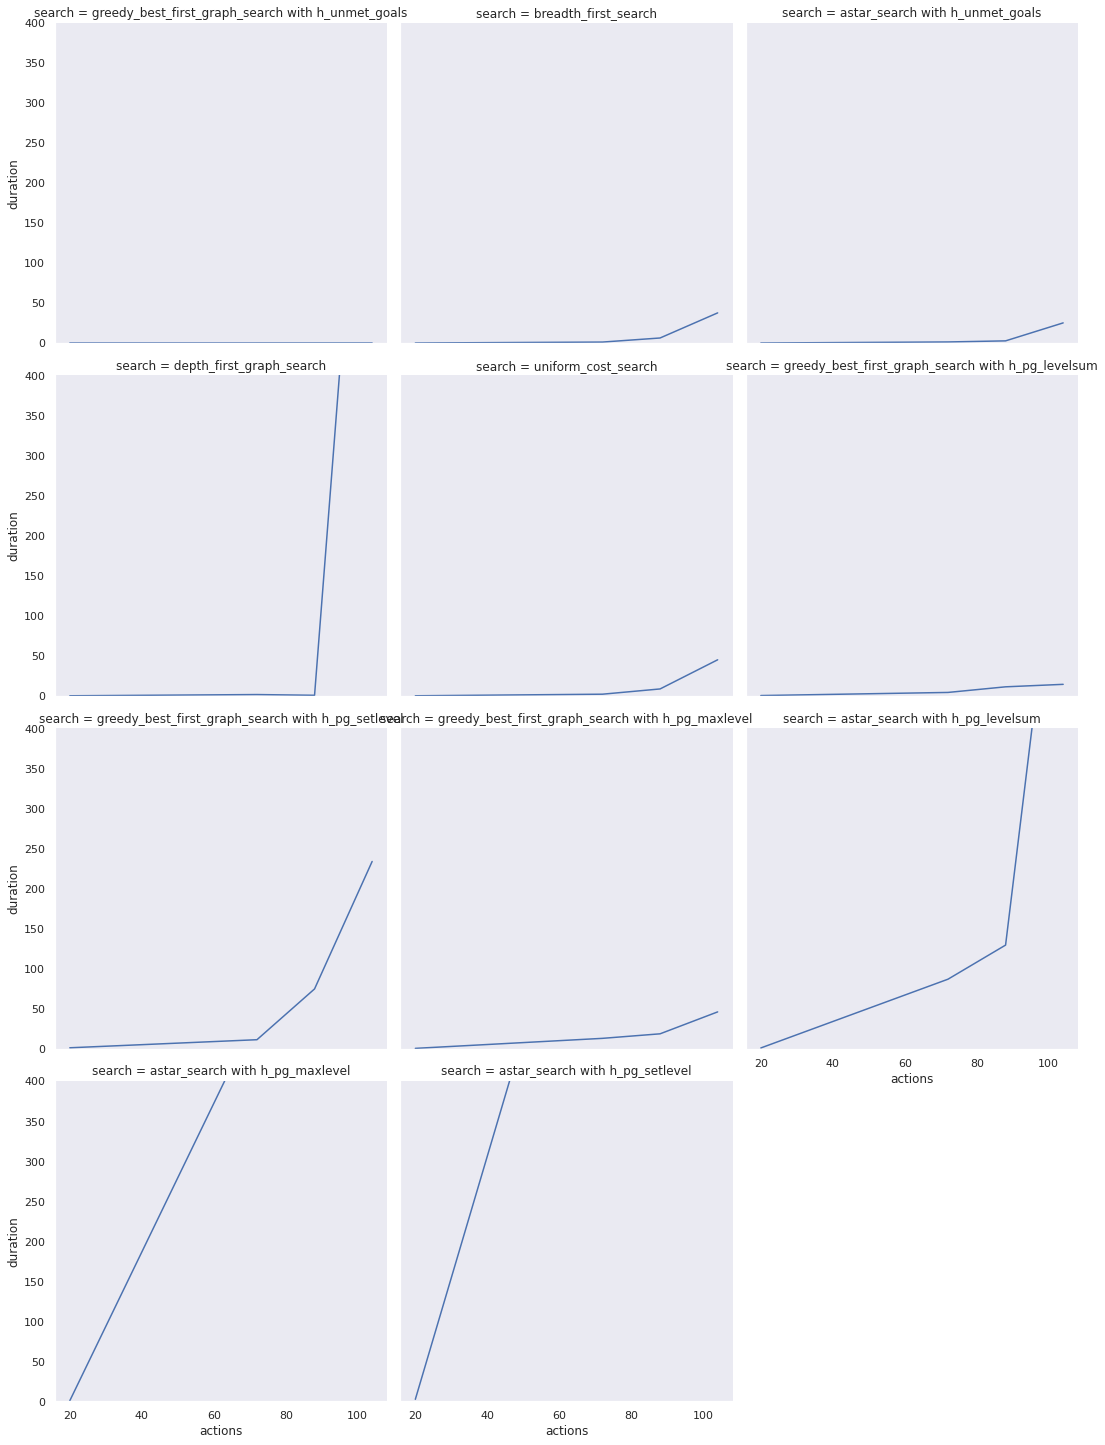

In [19]:
sns.relplot(data=df, x="actions", y="duration", col="search", col_wrap=3, kind="line")
plt.ylim(0, 400)